##  1- 导入数据和必要的库

In [1]:
#! wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
#! wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
#! pip install spectral

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## 创建 HybridSN 类

In [2]:
##定义 HybridSN 类

class_num = 16

class HybridSN(nn.Module):

  def __init__(self, num_classes=16):
    super(HybridSN, self).__init__()
    # conv1：（1, 30, 25, 25）， 8个 7x3x3 的卷积核 ==>（8, 24, 23, 23）
    self.conv1 = nn.Conv3d(1, 8, (7, 3, 3))
    # conv2：（8, 24, 23, 23）， 16个 5x3x3 的卷积核 ==>（16, 20, 21, 21）
    self.conv2 = nn.Conv3d(8, 16, (5, 3, 3))
    # conv3：（16, 20, 21, 21），32个 3x3x3 的卷积核 ==>（32, 18, 19, 19）
    self.conv3 = nn.Conv3d(16, 32, (3, 3, 3))
    # conv3_2d （576, 19, 19），64个 3x3 的卷积核 ==>（（64, 17, 17）
    self.conv3_2d = nn.Conv2d(576, 64, (3,3))
    # 全连接层（256个节点）
    self.dense1 =  nn.Linear(18496,256)
    # 全连接层（128个节点）
    self.dense2 =  nn.Linear(256,128)
    # 最终输出层(16个节点)
    self.out = nn.Linear(128, num_classes)
    #  Dropout（0.4)
    self.drop = nn.Dropout(p=0.4)

	######################
	#这里是优化的方向（一会还会添加注意力机制）
	######################
    #软最大化
    #self.soft = nn.LogSoftmax(dim=1)
    self.soft = nn.Softmax(dim=1)

    #加入BN归一化数据
    self.bn1=nn.BatchNorm3d(8)
    self.bn2=nn.BatchNorm3d(16)
    self.bn3=nn.BatchNorm3d(32)
    self.bn4=nn.BatchNorm2d(64)
    
    # 激活函数ReLU
    self.relu = nn.ReLU()
	#####################
	#####################

  #定义完了各个模块，记得在这里调用执行：
  def forward(self, x):

    out = self.relu(self.conv1(x))
    #out = self.bn1(out)#BN层

    out = self.relu(self.conv2(out))
    #out = self.bn2(out)#BN层
    
    out = self.relu(self.conv3(out))
    #out = self.bn3(out)#BN层

    out = out.view(-1, out.shape[1] * out.shape[2], out.shape[3], out.shape[4])# 进行二维卷积，因此把前面的 32*18 reshape 一下，得到 （576, 19, 19）
    #out = self.attention(out)#调用注意力机制
    out = self.relu(self.conv3_2d(out))
    #out = self.bn4(out)#BN层
    
    # flatten 操作，变为 18496 维的向量，
    out = out.view(out.size(0), -1)
    out = self.dense1(out)
    out = self.drop(out)
    out = self.dense2(out)
    out = self.drop(out)
    out = self.out(out)
    out = self.soft(out)
    return out


## 创建数据集
首先对高光谱数据实施PCA降维；然后创建 keras 方便处理的数据格式；然后随机抽取 10% 数据做为训练集，剩余的做为测试集。首先定义基本函数。

In [16]:
# 对高光谱数据 X 应用 PCA 变换
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# 在每个像素周围提取 patch ，然后创建成符合 keras 处理的格式
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # print(f'zeroPaddedX 的 shape为：', zeroPaddedX.shape)  (169, 169, 30)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    # print(patchesData.shape) (21025, 25, 25, 30)
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            print(patch.shape)
            patchesData[patchIndex, :, :, :] = patch
            
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test


## 下面读取并创建数据集

In [17]:
# 地物类别
class_num = 16
X = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

# 用于测试样本的比例
test_ratio = 0.90
# 每个像素周围提取 patch 的尺寸
patch_size = 25
# 使用 PCA 降维，得到主成分的数量
pca_components = 30

print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

print('\n... ... PCA tranformation ... ...')
X_pca = applyPCA(X, numComponents=pca_components)
print('Data shape after PCA: ', X_pca.shape)

print('\n... ... create data cubes ... ...')
X_pca, y = createImageCubes(X_pca, y, windowSize=patch_size)
print('Data cube X shape: ', X_pca.shape)
print('Data cube y shape: ', y.shape)

print('\n... ... create train & test data ... ...')
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y, test_ratio)
print('Xtrain shape: ', Xtrain.shape)
print('Xtest  shape: ', Xtest.shape)

# 改变 Xtrain, Ytrain 的形状，以符合 keras 的要求
Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components, 1)
Xtest  = Xtest.reshape(-1, patch_size, patch_size, pca_components, 1)
print('before transpose: Xtrain shape: ', Xtrain.shape) 
print('before transpose: Xtest  shape: ', Xtest.shape) 

# 为了适应 pytorch 结构，数据要做 transpose
Xtrain = Xtrain.transpose(0, 4, 3, 1, 2)
Xtest  = Xtest.transpose(0, 4, 3, 1, 2)
print('after transpose: Xtrain shape: ', Xtrain.shape) 
print('after transpose: Xtest  shape: ', Xtest.shape) 


""" Training dataset"""
class TrainDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.x_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)        
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

""" Testing dataset"""
class TestDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

# 创建 trainloader 和 testloader
trainset = TrainDS()
testset  = TestDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=128, shuffle=False, num_workers=0)

Hyperspectral data shape:  (145, 145, 200)
Label shape:  (145, 145)

... ... PCA tranformation ... ...
Data shape after PCA:  (145, 145, 30)

... ... create data cubes ... ...
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 

(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)

(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)

(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)

(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)

(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)
(25, 25, 30)

Data cube X shape:  (10249, 25, 25, 30)
Data cube y shape:  (10249,)

... ... create train & test data ... ...
Xtrain shape:  (1024, 25, 25, 30)
Xtest  shape:  (9225, 25, 25, 30)
before transpose: Xtrain shape:  (1024, 25, 25, 30, 1)
before transpose: Xtest  shape:  (9225, 25, 25, 30, 1)
after transpose: Xtrain shape:  (1024, 1, 30, 25, 25)
after transpose: Xtest  shape:  (9225, 1, 30, 25, 25)


## 训练网络

In [6]:
# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 网络放到GPU上
net = HybridSN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 开始训练
total_loss = 0
for epoch in range(100):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 优化器梯度归零
        optimizer.zero_grad()
        # 正向传播 +　反向传播 + 优化 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item()))

print('Finished Training')

[Epoch: 1]   [loss avg: 21.2510]   [current loss: 2.6558]
[Epoch: 2]   [loss avg: 21.1668]   [current loss: 2.6480]
[Epoch: 3]   [loss avg: 21.1388]   [current loss: 2.6558]
[Epoch: 4]   [loss avg: 21.1248]   [current loss: 2.5933]
[Epoch: 5]   [loss avg: 21.1164]   [current loss: 2.5699]
[Epoch: 6]   [loss avg: 21.1107]   [current loss: 2.6793]
[Epoch: 7]   [loss avg: 21.1067]   [current loss: 2.6324]
[Epoch: 8]   [loss avg: 21.1037]   [current loss: 2.6480]
[Epoch: 9]   [loss avg: 21.1014]   [current loss: 2.6793]
[Epoch: 10]   [loss avg: 21.0995]   [current loss: 2.6480]
[Epoch: 11]   [loss avg: 21.0980]   [current loss: 2.5777]
[Epoch: 12]   [loss avg: 21.0967]   [current loss: 2.6246]
[Epoch: 13]   [loss avg: 21.0957]   [current loss: 2.6715]
[Epoch: 14]   [loss avg: 21.0947]   [current loss: 2.5933]
[Epoch: 15]   [loss avg: 21.0939]   [current loss: 2.6793]
[Epoch: 16]   [loss avg: 21.0932]   [current loss: 2.5543]
[Epoch: 17]   [loss avg: 21.0926]   [current loss: 2.6480]
[Epoch

KeyboardInterrupt: 

## 模型测试

In [68]:
count = 0
net = net.eval()
# 模型测试
for inputs, _ in test_loader:
    inputs = inputs.to(device)
    outputs = net(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test =  outputs
        count = 1
    else:
        y_pred_test = np.concatenate( (y_pred_test, outputs) )

# 生成分类报告
classification = classification_report(ytest, y_pred_test, digits=4)
print(classification)

              precision    recall  f1-score   support

         0.0     0.9706    0.8049    0.8800        41
         1.0     0.9121    0.9128    0.9125      1285
         2.0     0.9439    0.9237    0.9337       747
         3.0     0.9167    0.8263    0.8691       213
         4.0     0.8348    0.8713    0.8526       435
         5.0     0.9593    0.9680    0.9636       657
         6.0     0.9600    0.9600    0.9600        25
         7.0     0.9613    0.9814    0.9712       430
         8.0     1.0000    0.7222    0.8387        18
         9.0     0.9473    0.9657    0.9564       875
        10.0     0.9391    0.9692    0.9539      2210
        11.0     0.9165    0.8221    0.8667       534
        12.0     0.9492    0.9081    0.9282       185
        13.0     0.9507    0.9824    0.9663      1139
        14.0     0.8829    0.8473    0.8647       347
        15.0     0.9796    0.5714    0.7218        84

    accuracy                         0.9324      9225
   macro avg     0.9390   

... ... row  0  handling ... ...
... ... row  20  handling ... ...
... ... row  40  handling ... ...
... ... row  60  handling ... ...
... ... row  80  handling ... ...
... ... row  100  handling ... ...
... ... row  120  handling ... ...
... ... row  140  handling ... ...


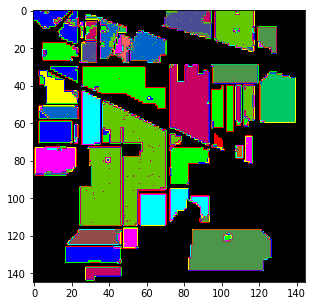

In [69]:
## 显示分类结果
# load the original image
X = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
y = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

height = y.shape[0]
width = y.shape[1]

X = applyPCA(X, numComponents= pca_components)
X = padWithZeros(X, patch_size//2)

# 逐像素预测类别
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        if int(y[i,j]) == 0:
            continue
        else :
            image_patch = X[i:i+patch_size, j:j+patch_size, :]
            image_patch = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1)
            X_test_image = torch.FloatTensor(image_patch.transpose(0, 4, 3, 1, 2)).to(device)                                   
            prediction = net(X_test_image)
            prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
            outputs[i][j] = prediction+1
    if i % 20 == 0:
        print('... ... row ', i, ' handling ... ...')
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5)) # 查看结果